# Gate F - Classification via Interference

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[1]{\left\langle{#1}\right\rangle}$$

### (Step 3) Learning via interference
The prediction for the test set has to be computed based on the following transformation:

\begin{align}
    \left|\Phi_{f}\right\rangle 
                = & \Big(\mathbb{1}^{\otimes 2} \otimes F \Big) \left|\Phi_{d}\right\rangle \nonumber \\ 
                = & (\mathbb{1}^{\otimes d} \otimes F )\Bigg[\frac{1}{\sqrt{2^d}}\sum_{b=1}^{2^d} \left|b\right\rangle \left|x_b, y_b\right\rangle\Bigg] \otimes \left|x^{(test)}\right\rangle \left|0\right\rangle  \nonumber \\ 
                = & \frac{1}{\sqrt{2^d}}\sum_{b=1}^{2^d} \left|b\right\rangle \left|x_b, y_b\right\rangle\left|x^{(test)}\right\rangle \left|f_b\right\rangle
\end{align}

where $f_b$ represents the $b$-th prediction for $\tilde{x}$ given the  $b$-th training set. 

## Cosine Classifier

Given a training point $(x_{b}, y_{b})$ at random, the probability of $y^{(\text{test})}$ and $y_{b}$ being equal is a function of the similarity between $x^{(\text{test})}$ and $x_{b}$.

Predict a similar target class for similar input features
\begin{align}\label{equation:cosine classifier}
    Pr\left(y^{(\text{test})} = y_{b}\right) = \frac{1}{2}+\frac{\left[d\left(x_{b}, x^{(\text{test})}\right)\right]^2}{2}
\end{align}

Final classification rule:
 \begin{align} \label{classification_rule}
    y^{(\text{test})} = 
    \begin{cases} y_{b}, & \mbox{if } Pr\left(y^{(\text{test})} = y_{b}\right) > \frac{1}{2} \\ 1- y_{b} 
                      & \mbox{otherwise }  
    \end{cases}
\end{align}

## Cosine Classifier (II)

+ the prediction depends on the squared cosine distance between the two vectors

+ max dissimilarity occurs when training and test observations are orthogonal 

&emsp; &emsp; &emsp; &emsp; $\rightarrow$ uniform probability distribution in the two classes for $y^{(test)}$

+ the cosine classifier performs well only if training and test belongs to the same class

## Quantum Cosine Classifier

The quantum circuit that implements the cosine classifier encodes data into three different registers: the training vector $x_b$, the training label $y_b$ and the test point $x^{(test)}$. One more qubit is used to store the prediction. 

The algorithm is made of three steps: **State Preparation**, **Swap test**, **Controlled-X**

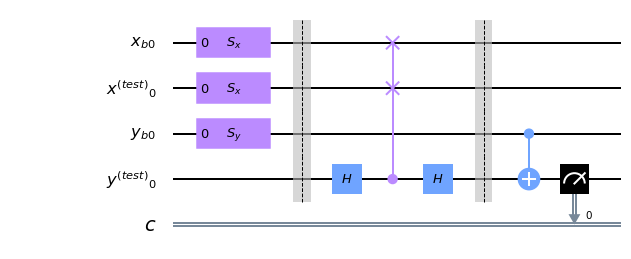

In [2]:
import sys
sys.path.insert(1, '../')
from Utils import *
from modeling import *

x_train = [random.uniform(-1, 1), random.uniform(0, 1)]
x_train_norm = normalize_custom(x_train)
x_test = [random.uniform(-1, 1), random.uniform(0, 1)]
x_test_norm = normalize_custom(x_test)
class0 = [1,0]

qc = quantum_cosine_classifier(x_train_norm, x_test_norm, class0)
qc.draw(output='mpl', scale=.7)

### Step 1: State Preparation

Data are encoded into three different quantum registers. Since each set of data ($x$ and $y$) is stored separately, the state preparation routine can be performed independently for each qubit.

$$ \ket{\Phi_1} = \Big( S_{x_{b}} \otimes S_{x^{(test)}} \otimes S_{y_{b}} \otimes  \mathbb{1}  \Big) \ket{0} \ket{0} \ket{0} \ket{0}  = \ket{x_{b}} \ket{x^{(test)}} \ket{y_{b}} \ket{0}
$$

where $S_{(x)}$ is the routine which encodes in the amplitudes of a qubit a $2$-dimensional real vector $x$.

### Step 2: Execution of the swap test

In the second step, the swap-test transforms the amplitudes of the qubit $y^{(test)}$ as a function of the squared cosine distance:

\begin{align}
\ket{\Phi_2} & = 
\big(\mathbb{1} \otimes \mathbb{1} \otimes \mathbb{1} \otimes H\big)
\big(\text{cswap} \otimes \mathbb{1} \otimes C \big) 
\big(\mathbb{1} \otimes \mathbb{1} \otimes \mathbb{1} \otimes H\big) 
\ket{x_{b}} \ket{x^{(test)}} \ket{y_{b}} \ket{0} \nonumber \\ 
   & = \frac{1}{2}
   \Big(
   \big( \ket{x_{b}} \ket{x^{(test)}} + \ket{x^{(test)}} \ket{x_{b}} \big)\ket{y_{b}} \ket{0} + 
  \big(\ket{x_{b}} \ket{x^{(test)}} - \ket{x^{(test)}} \ket{x_{b}} \big)\ket{y_{b}} \ket{1} \Big)
\end{align}

where $H$ is the Hadamard gate, cswap is the controlled-swap operation which uses the fourth qubit (position of gate *C*) as control  qubit to swap $\ket{x_{b}}$ and $\ket{x^{(test)}}$.
After the execution of the swap test the probability to redout the basis state $\ket{0}$, that is the probability for the *test* observation to be classified in class $0$ is:
\begin{align}
    P(y^{(test)} = \left|0\right\rangle) = 
    \frac{1}{2}+\frac{|\langle x_{b}|x^{(test)} \rangle|^2}{2}
\end{align}

### Step 3: Controlled Pauli-*X* gate

The third step consists in applying a controlled Pauli-$X$ rotation using the control qubit that encodes the label of the training vector. This implies that $y^{(test)}$ is left untouched if  $x_{b}$ belongs to the class $0$. Otherwise,
the amplitudes of the $y^{(test)}$ qubit are exchanged,
and the probability $P(y^{(test)} = 1)$ is higher as the similarity between the two vectors increases.

$$
\left|\Phi_3\right\rangle = \big(\mathbb{1} \otimes \mathbb{1} \otimes \text{C-X} \big) \left|\Phi_2\right\rangle
$$

Thus, the probability amplitudes of the two basis states of $y^{(test)}$ lead to a classification rule that is equivalent to the classic cosine classifier.

## Behaviour of Quantum Cosine Classifier

To study the behaviour of the quantum cosine classifier, $1000$ random datasets are generated. Each dataset is made  of a training point $(x_{b}, y_{b})$ and a test point $x^{(test)}$

In [3]:
n_shots = 100 # n° of shots for the quantum circuit
n=1000 # n° of datasets

x = [] # vector that stores classical cosine prediction
x_err = [] # cosine distance between vectors

P0 = [] # list of values if the training obs belgons to class 1
P1 = [] # list of values if the training obs belgons to class 1

for i in np.arange(n):
    '''Random generated dataset'''
    x_train = [random.uniform(-1, 1), random.uniform(0, 1)]
    x_train_norm = normalize_custom(x_train)
    x_test = [random.uniform(-1, 1), random.uniform(0, 1)]
    x_test_norm = normalize_custom(x_test)

    '''Compute cosine distance and append it to x'''
    d_cos = cosine_similarity([x_train], [x_test])[0][0]
    x.append(d_cos)

    '''If x_train belongs to class 0'''
    qc = quantum_cosine_classifier(x_train_norm, x_test_norm, [1,0])
    r = exec_simulator(qc, n_shots)
    P_q = r['0']/n_shots
    P0.append(P_q)
    d_cos_err = np.sqrt(2*P_q-1)
    x_err.append( d_cos_err )


P0 = np.array(P0)
x = np.array(x)
x_err = np.array(x_err)

order = x.argsort()

x = x[order[::-1]]
P0 = P0[order[::-1]]
x_err = x_err[order[::-1]]

err = [ abs(x1 - x2) for (x1, x2) in zip(abs(x), x_err)]
err = np.array(err)
P1 = 1-P0

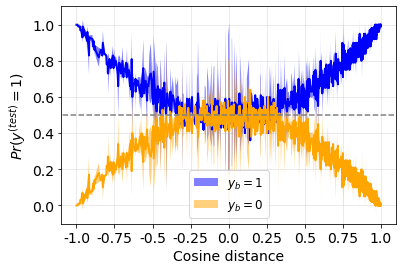

In [5]:
quantum_cos_random_data(x, P0, P1, err)